In [1]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gvnsng","key":"2e8acd50e3b69cea9d094e64e00c7486"}'}

In [2]:
!pip install --quiet kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mczielinski/bitcoin-historical-data

Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
License(s): CC-BY-SA-4.0
 67% 65.0M/96.8M [00:00<00:00, 670MB/s]
100% 96.8M/96.8M [00:00<00:00, 738MB/s]


In [4]:
!unzip bitcoin-historical-data.zip

Archive:  bitcoin-historical-data.zip
  inflating: btcusd_1-min_data.csv   


In [5]:
!pip install --upgrade plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 47.7 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [6]:
!pip install chart_studio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 5.0 MB/s eta 0:00:00


In [7]:
import os

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error

#df = pd.read_csv('btcusd_1-min_data.csv')
#df.tail()

In [8]:
!ls

bitcoin-historical-data.zip  btcusd_1-min_data.csv  kaggle.json  sample_data


In [9]:
df = pd.read_csv('btcusd_1-min_data.csv', index_col='Timestamp', parse_dates=['Timestamp'])

In [10]:
df.index = pd.to_datetime(df.index, unit='s')

In [11]:
df.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


In [12]:
diffs = df.index.to_series().diff().dropna()
print(diffs.value_counts().head(10))

Timestamp
0 days 00:01:00    7219835
0 days 19:21:00          1
Name: count, dtype: int64


In [13]:
print(type(df.index))
print(df.index.min(), "→", df.index.max())

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
2012-01-01 10:01:00 → 2025-09-23 23:57:00


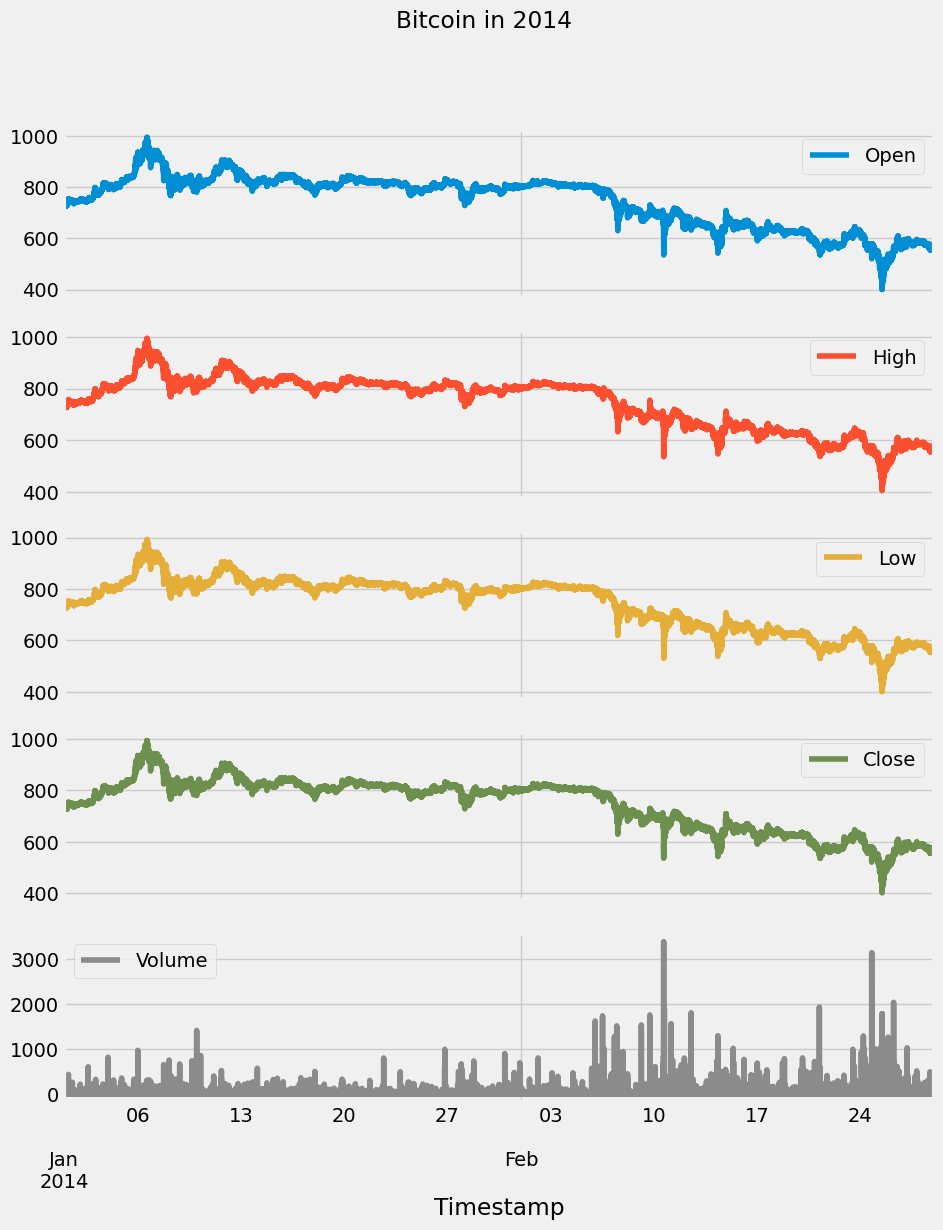

In [14]:
df.loc['2014-01':'2014-02'].plot(subplots=True, figsize=(10,12))
plt.suptitle('Bitcoin in 2014')
plt.show()

In [15]:
df.shape

(7219837, 5)

In [16]:
df_day = df.resample('D').mean()

In [17]:
df_day.shape

(5015, 5)

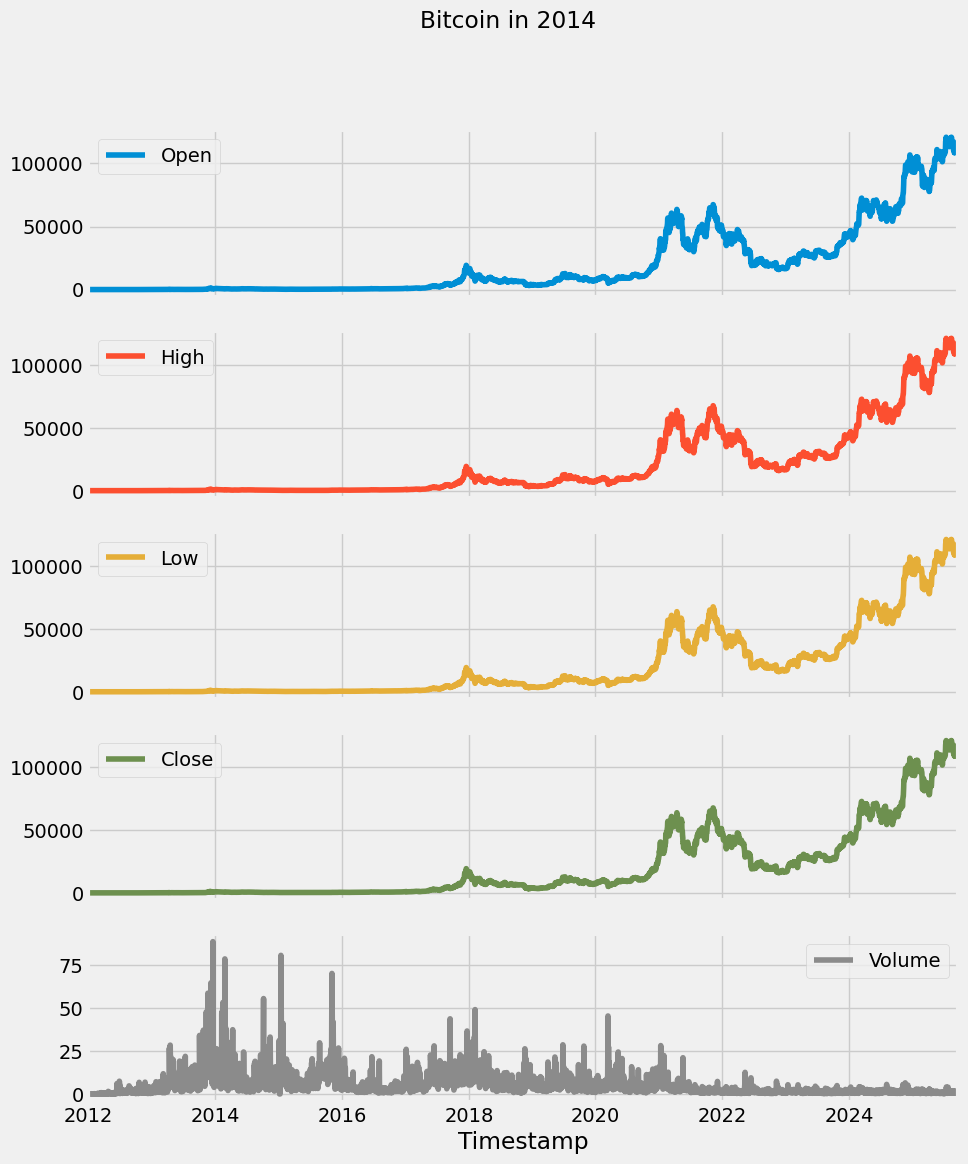

In [18]:
df_day.loc['2012': '2025'].plot(subplots=True, figsize=(10,12))
plt.suptitle('Bitcoin in 2014')
plt.show()

<Axes: xlabel='Timestamp'>

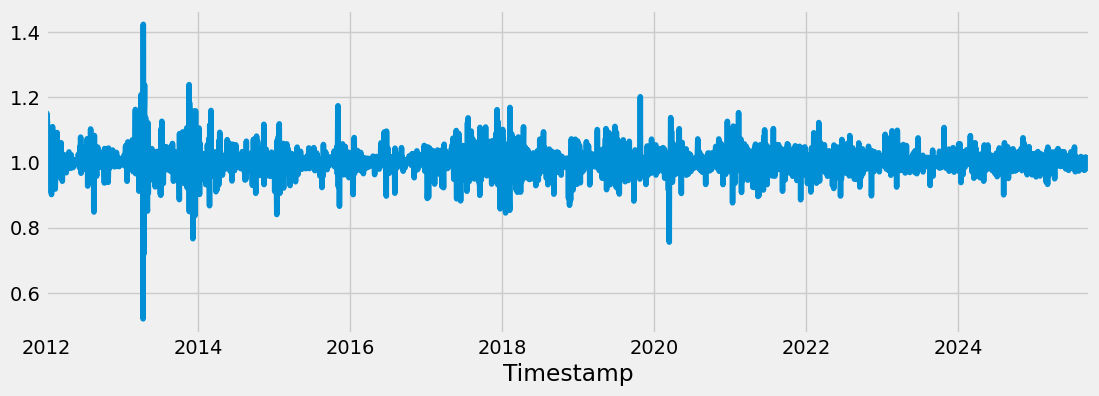

In [19]:
df_day['Change'] = df_day.High.div(df_day.High.shift())
df_day['Change'].plot(figsize=(12, 4))
# df_day.High.div(df_day.High.shift()).sub(1) is same as .pct_change()

<Axes: xlabel='Timestamp'>

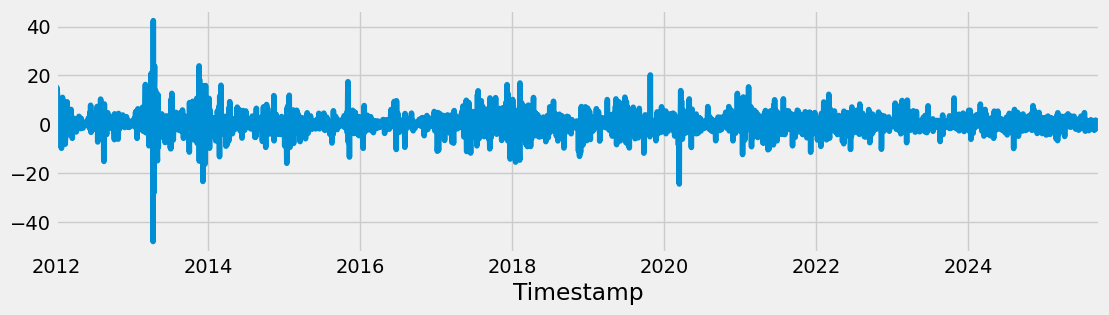

In [21]:
df_day['Return'] = df_day['Change'].sub(1).mul(100)
df_day['Return'].plot(figsize=(12,3))

<Axes: xlabel='Timestamp'>

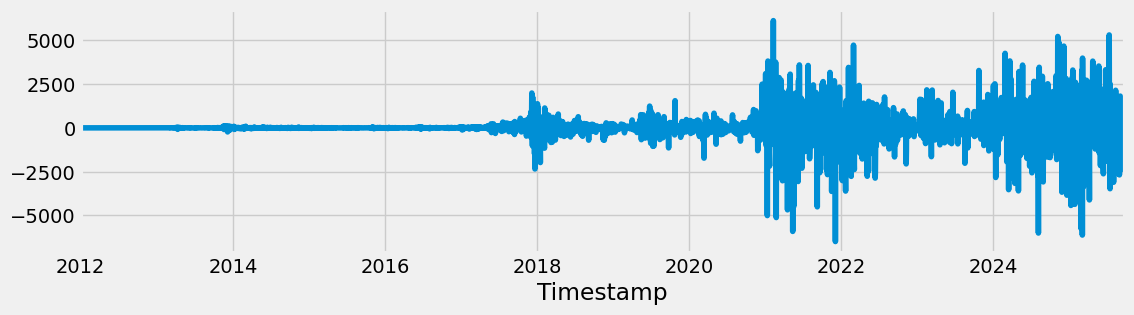

In [22]:
df_day['High'].diff().plot(figsize=(12,3))

In [23]:
# Normalizing and comparison
# Both stocks start from 100
# if scales are different then cant compare without normalization

#normalized_google = google.High.div(google.High.iloc[0]).mul(100)
#normalized_microsoft = microsoft.High.div(microsoft.High.iloc[0]).mul(100)
#normalized_google.plot()
#normalized_microsoft.plot()
#plt.legend(['Google','Microsoft'])
#plt.show()

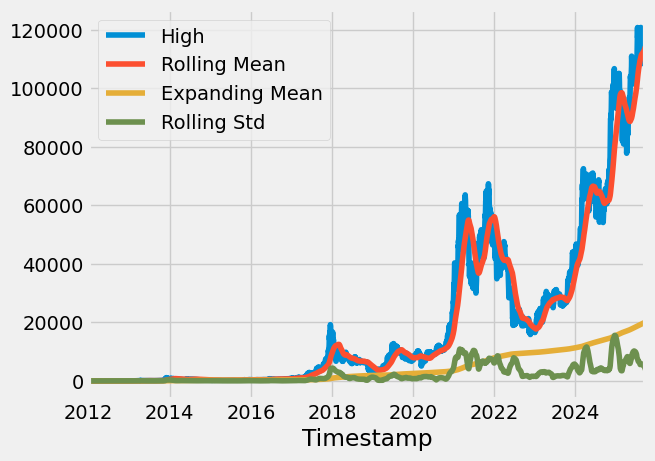

In [24]:
df_day.High.plot()
df_day.High.rolling('90D').mean().plot()
df_day.High.expanding().mean().plot()
df_day.High.rolling('90D').std().plot()
plt.legend(['High','Rolling Mean', 'Expanding Mean', 'Rolling Std'])
plt.show()

In [25]:
print(df.loc['2025-01'].head())

                        Open     High      Low    Close    Volume
Timestamp                                                        
2025-01-01 00:00:00  93347.0  93395.0  93347.0  93395.0  0.016150
2025-01-01 00:01:00  93426.0  93436.0  93426.0  93436.0  0.064916
2025-01-01 00:02:00  93448.0  93499.0  93443.0  93479.0  8.307030
2025-01-01 00:03:00  93478.0  93478.0  93478.0  93478.0  0.021465
2025-01-01 00:04:00  93472.0  93472.0  93450.0  93450.0  0.236915


In [26]:
pd.api.types.is_datetime64_any_dtype(df.index)

True

In [27]:
import plotly.io as pio
pio.renderers.default = "colab"

In [28]:
import plotly.graph_objects as go

jan = df.loc['2025-01-01 00:00': '2025-01-01 03:00']

fig = go.Figure(data=go.Ohlc(x=jan.index,
                             open=jan['Open'],
                             high=jan['High'],
                             low=jan['Low'],
                             close=jan['Close']))
fig.show()


In [29]:
import plotly.graph_objects as go

jan = df.loc['2025-01-01 00:00': '2025-01-01 03:00']

trace = go.Candlestick(x=jan.index,
                open=jan.Open,
                high=jan.High,
                low=jan.Low,
                close=jan.Close)
data = [trace]
iplot(data, filename='simple_candlestick')

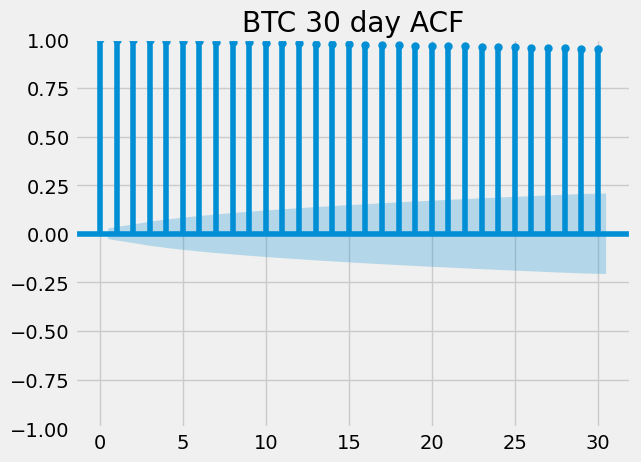

In [30]:
plot_acf(df_day.High,lags=30,title="BTC 30 day ACF")
plt.show()

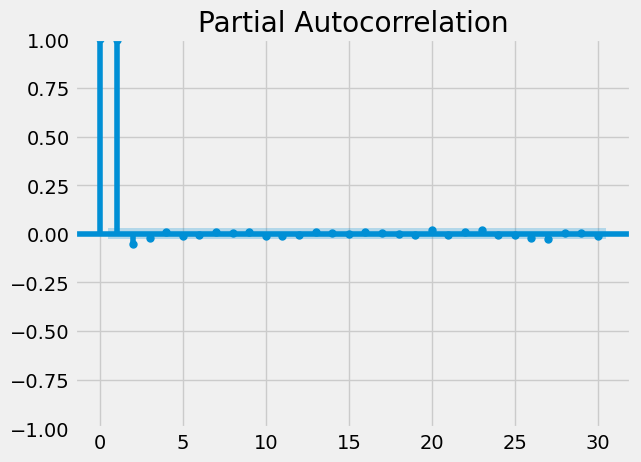

In [31]:
plot_pacf(df_day.High, lags=30)
plt.show()

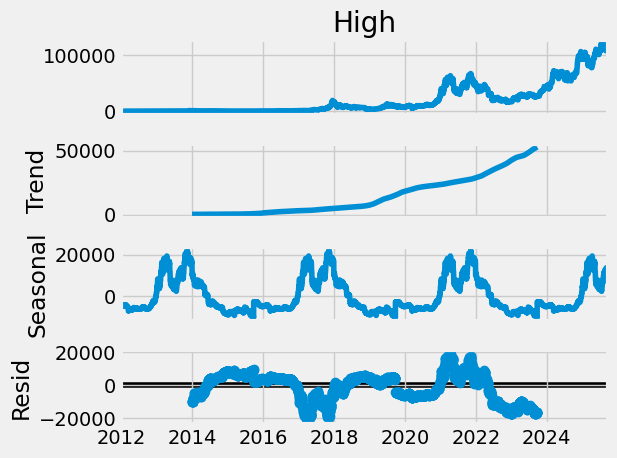

In [32]:
decomposed_btc_volume = sm.tsa.seasonal_decompose(df_day.High,period=1460) # 1460 days = 4 yrs, clear upward trend
figure = decomposed_btc_volume.plot()
plt.show()

<Axes: xlabel='Timestamp'>

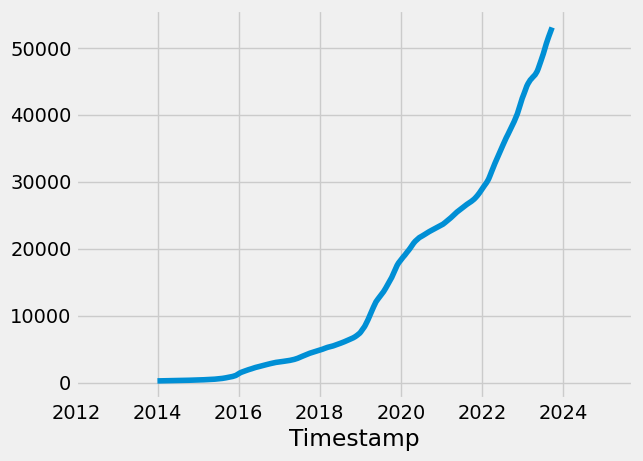

In [33]:
decomposed_btc_volume.trend.plot()

<Axes: xlabel='Timestamp'>

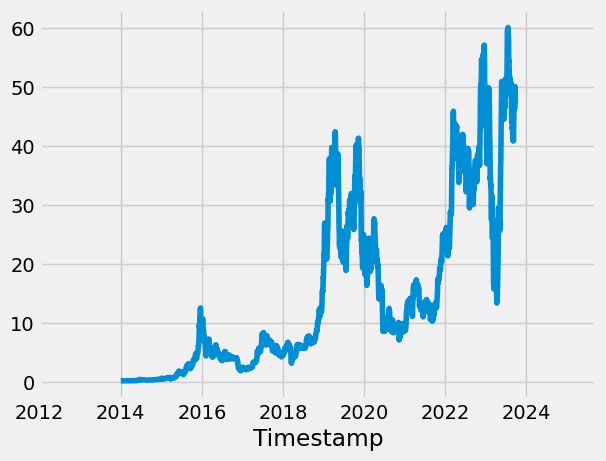

In [34]:
# convert non-stationary time series to stationary using diff
decomposed_btc_volume.trend.diff().plot()

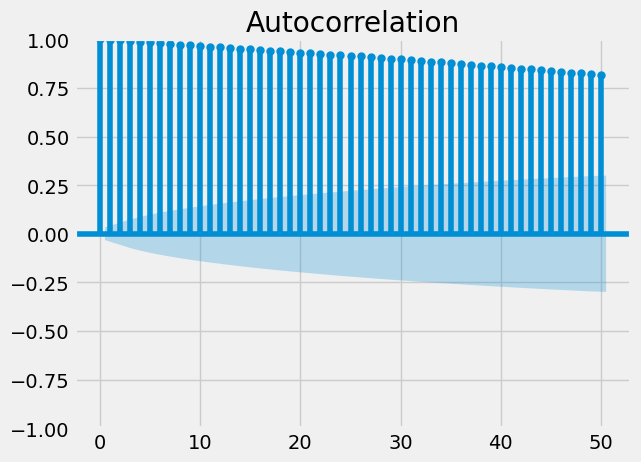

         lb_stat  lb_pvalue
10  34374.239180        0.0
20  66424.373825        0.0
30  96312.577302        0.0


In [35]:
residuals = decomposed_btc_volume.resid.dropna()

plot_acf(residuals, lags=50)
plt.show()

ljung_box = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(ljung_box)

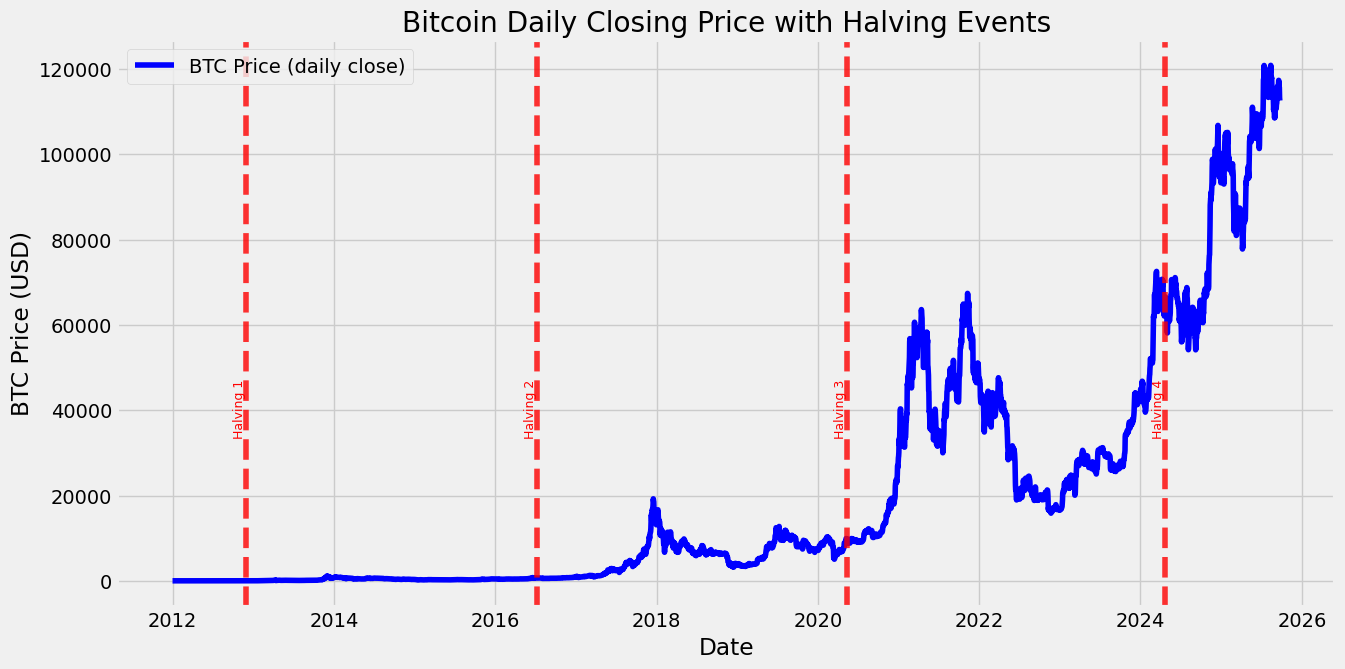

In [36]:
# daily close prices
btc_close = df_day['Close']

# known halving dates
halvings = [
    "2012-11-28",  # 1st
    "2016-07-09",  # 2nd
    "2020-05-11",  # 3rd
    "2024-04-20",  # 4th
]

# plot
plt.figure(figsize=(14, 7))
plt.plot(btc_close, label="BTC Price (daily close)", color="blue")

# halvings as vertical lines
for i, h in enumerate(halvings, 1):
    hdate = pd.to_datetime(h)
    plt.axvline(hdate, color="red", linestyle="--", alpha=0.8)
    plt.text(hdate, btc_close.max()/3, f"Halving {i}",
             rotation=90, va="center", ha="right", color="red", fontsize=9)

plt.title("Bitcoin Daily Closing Price with Halving Events")
plt.xlabel("Date")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.show()

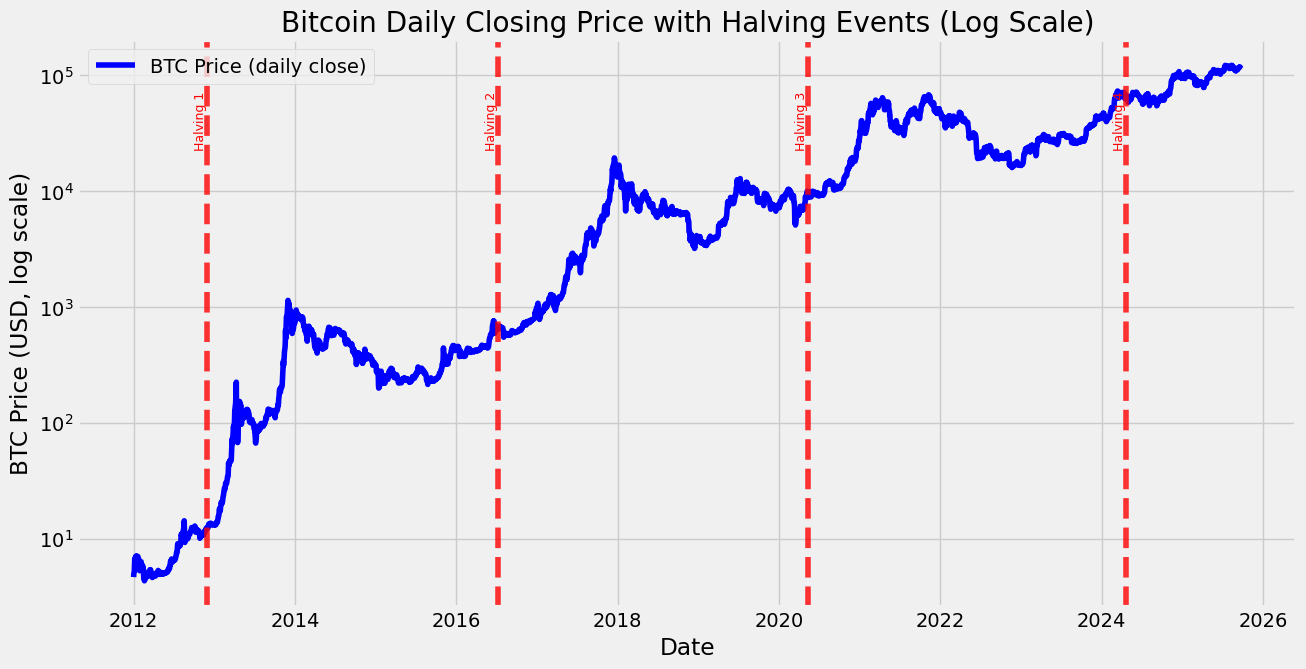

In [37]:
# daily close prices
btc_close = df_day['Close']

# known halving dates
halvings = [
    "2012-11-28",  # 1st
    "2016-07-09",  # 2nd
    "2020-05-11",  # 3rd
    "2024-04-20",  # 4th
]

# plot
plt.figure(figsize=(14, 7))
plt.plot(btc_close, label="BTC Price (daily close)", color="blue")
plt.yscale("log")  # log scale

# halvings as vertical lines
for i, h in enumerate(halvings, 1):
    hdate = pd.to_datetime(h)
    plt.axvline(hdate, color="red", linestyle="--", alpha=0.8)
    plt.text(hdate, btc_close.max()/3, f"Halving {i}",
             rotation=90, va="center", ha="right", color="red", fontsize=9)

plt.title("Bitcoin Daily Closing Price with Halving Events (Log Scale)")
plt.xlabel("Date")
plt.ylabel("BTC Price (USD, log scale)")
plt.legend()
plt.show()

In [38]:
adf = adfuller(df_day.Volume)
print("p-value of BTC: {}".format(float(adf[1])))
# As BTC has p-value less than 0.05, null hypothesis is rejected and this is not a random walk.

p-value of BTC: 4.875856547171139e-06


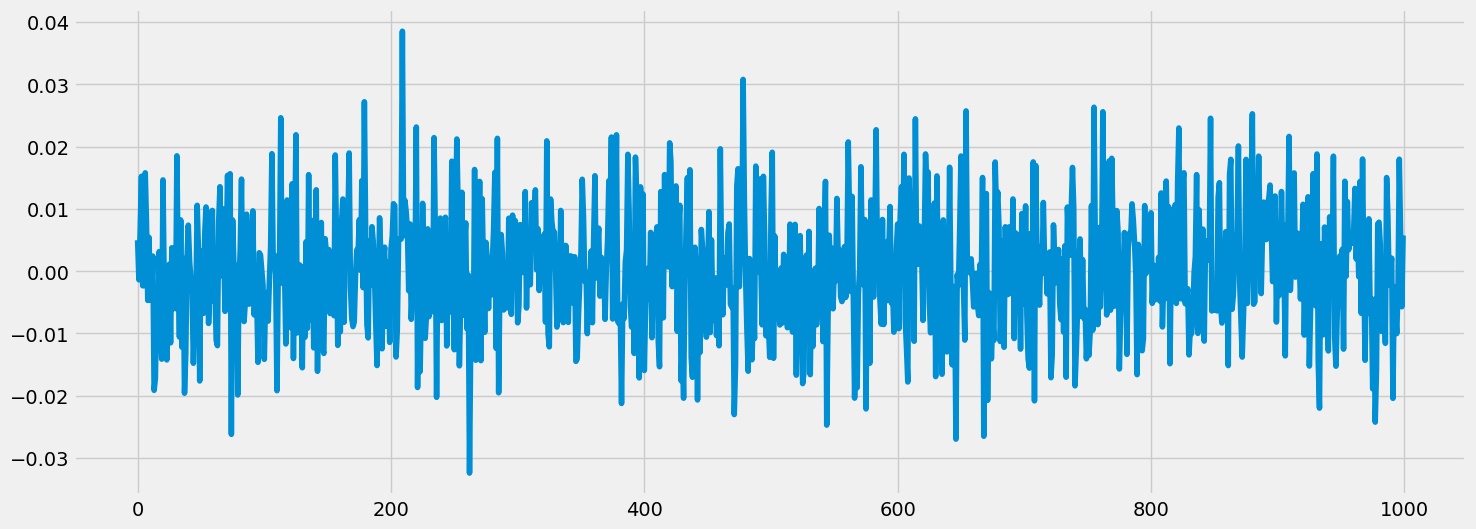

In [39]:
seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
plt.plot(random_walk)
plt.show()

In [40]:
fig = ff.create_distplot([random_walk],['Random Walk'],bin_size=0.001)
iplot(fig, filename='Basic Distplot')

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [42]:
df_day.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'Return'], dtype='object')

In [43]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(df_day["Close"])

print("ADF Test on Original Series")
print(f"ADF Statistic : {result_original[0]:.4f}")
print(f"p-value       : {result_original[1]:.4f}")
print("Critical Values:")
for key, value in result_original[4].items():
    print(f"   {key}: {value:.4f}")

if result_original[1] < 0.05:
    print("✅ The original series is Stationary.\n")
else:
    print("❌ The original series is Non-Stationary.\n")

# Apply first-order differencing
df_day["Close_Diff"] = df_day["Close"].diff()

# Perform the ADF test on the differenced series
result_diff = adfuller(df_day["Close_Diff"].dropna())

print("ADF Test on Differenced Series")
print(f"ADF Statistic : {result_diff[0]:.4f}")
print(f"p-value       : {result_diff[1]:.4f}")
print("Critical Values:")
for key, value in result_diff[4].items():
    print(f"   {key}: {value:.4f}")

if result_diff[1] < 0.05:
    print("✅ The differenced series is Stationary.")
else:
    print("❌ The differenced series is Non-Stationary.")


ADF Test on Original Series
ADF Statistic : 0.3816
p-value       : 0.9808
Critical Values:
   1%: -3.4317
   5%: -2.8621
   10%: -2.5671
❌ The original series is Non-Stationary.

ADF Test on Differenced Series
ADF Statistic : -9.9091
p-value       : 0.0000
Critical Values:
   1%: -3.4317
   5%: -2.8621
   10%: -2.5671
✅ The differenced series is Stationary.


## ARIMA

In [44]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')

In [45]:
# daily
df_day = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

In [46]:
df_day['Weighted_Price'] = (df_day.Open+df_day.Close+df_day.High+df_day.Low)/4
df_month['Weighted_Price'] = (df_month.Open+df_month.Close+df_month.High+df_month.Low)/4
df_year['Weighted_Price'] = (df_year.Open+df_year.Close+df_year.High+df_year.Low)/4
df_Q['Weighted_Price'] = (df_Q.Open+df_Q.Close+df_Q.High+df_Q.Low)/4

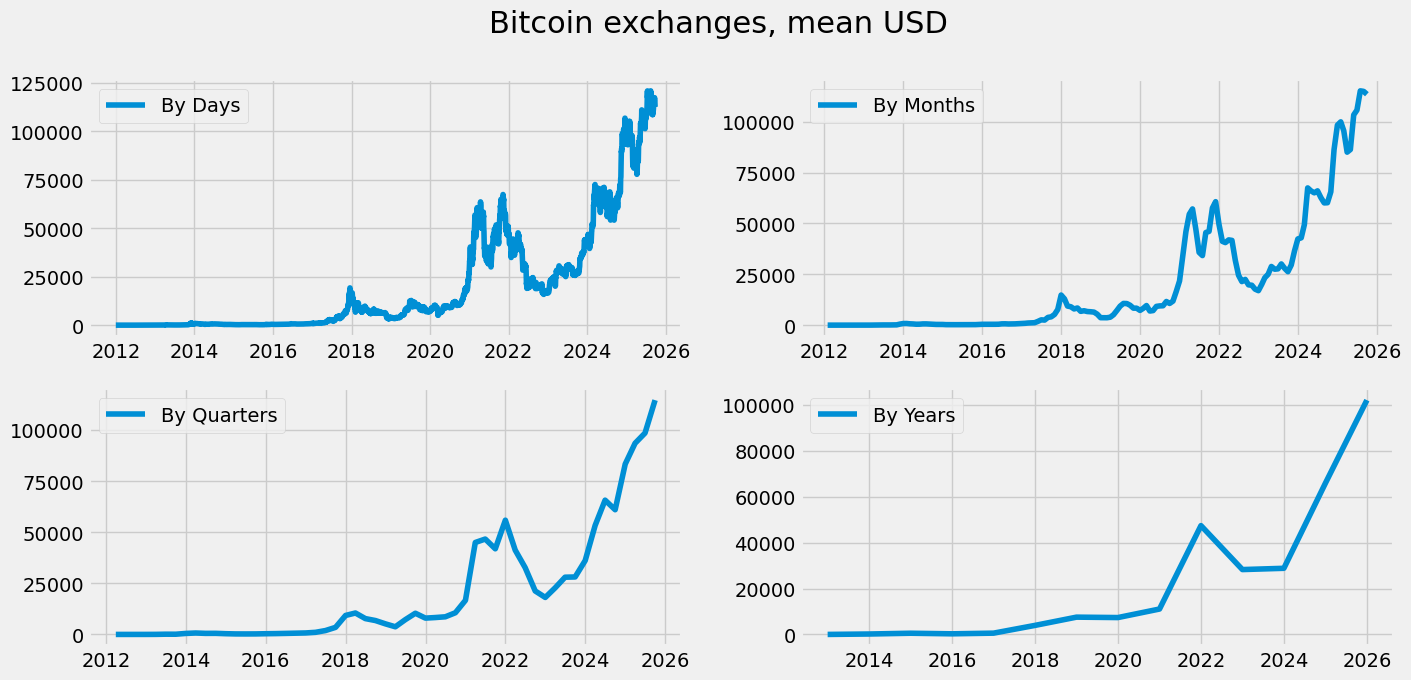

In [47]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df_day.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.994062


<Figure size 1200x600 with 0 Axes>

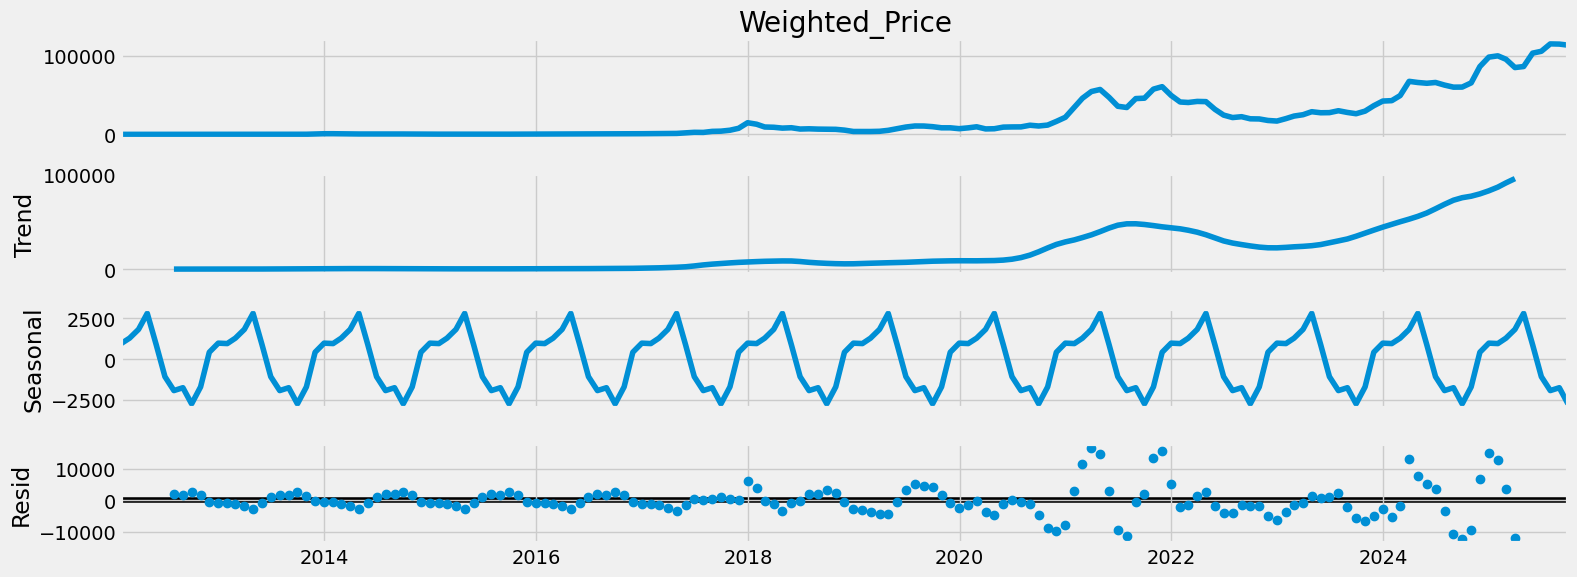

In [48]:
plt.figure(figsize=[12,6])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [49]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.994062


In [50]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.029379


Dickey–Fuller test: p=0.000000


<Figure size 1500x700 with 0 Axes>

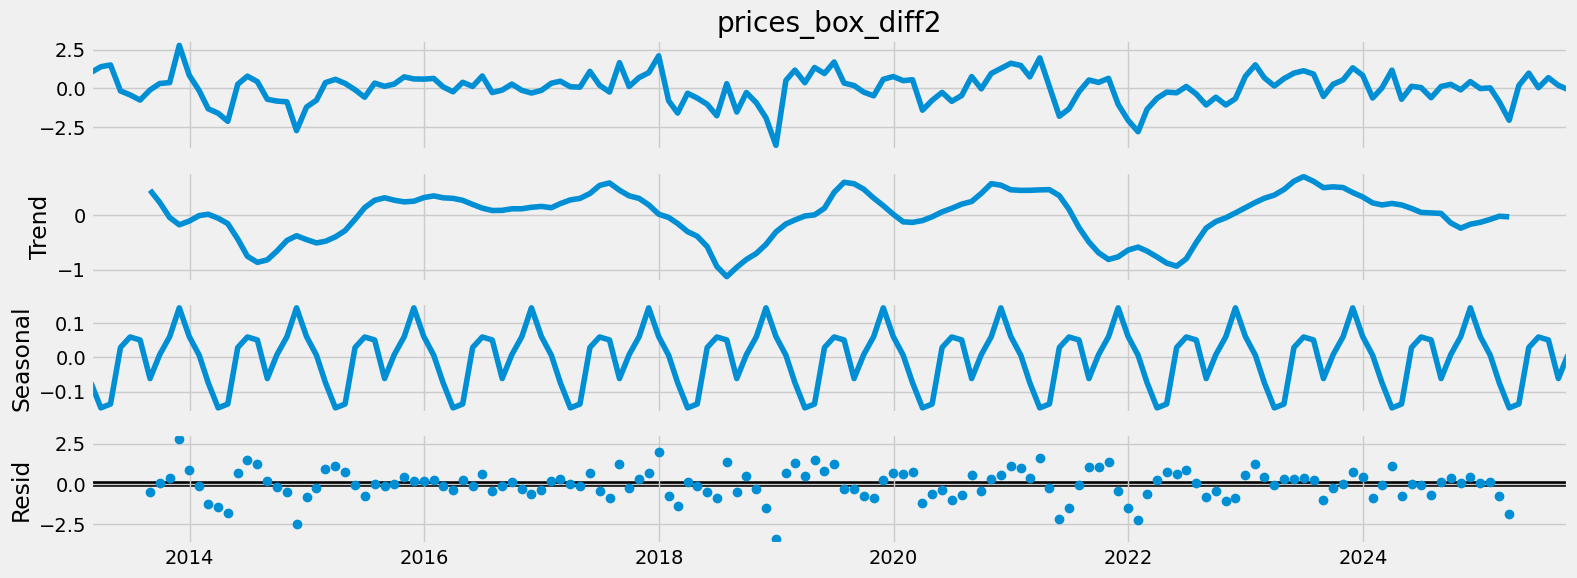

In [51]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

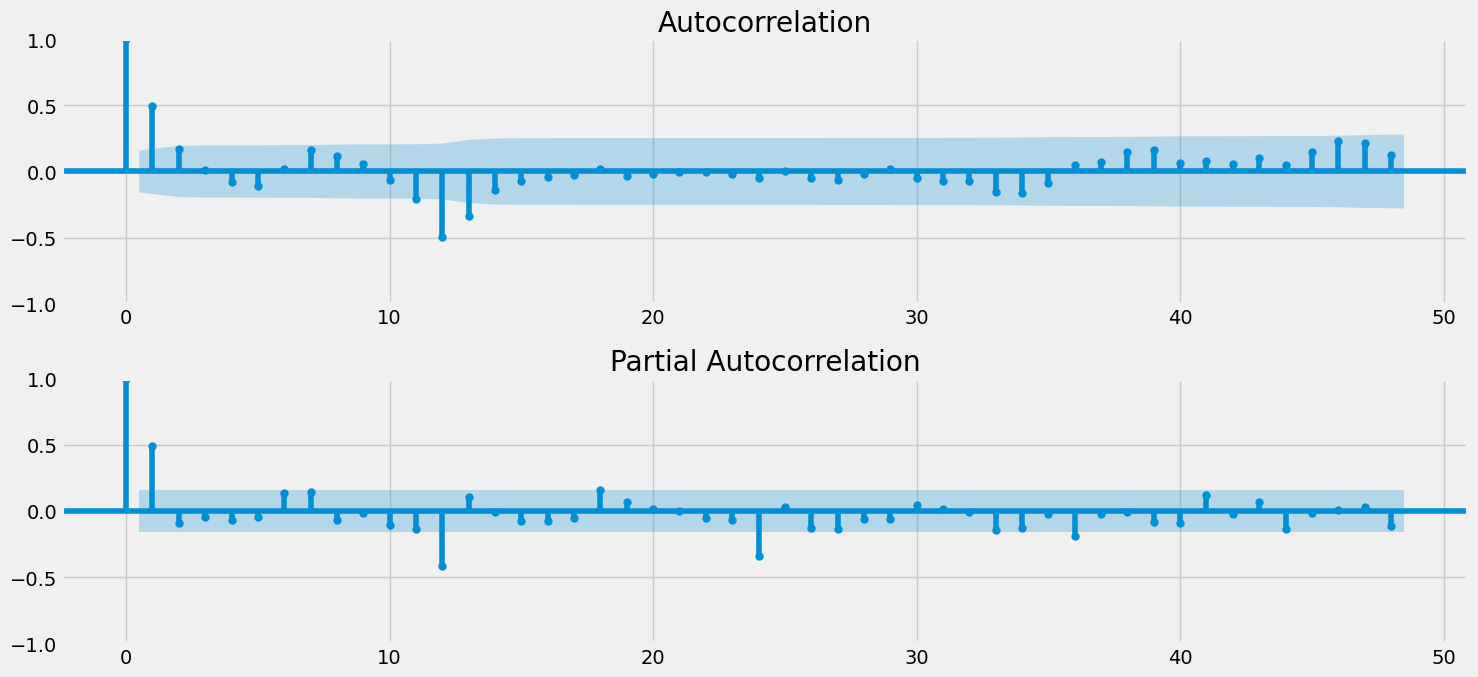

In [52]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [53]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [54]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  306.640243
7   (0, 1, 0, 1)  306.701446
37  (2, 0, 0, 1)  306.954806
25  (1, 1, 0, 1)  307.066580
13  (0, 2, 0, 1)  307.226530
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  165
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -150.320
Date:                              Wed, 24 Sep 2025   AIC                            306.640
Time:                                      08:57:17   BIC                            315.712
Sample:                                  01-31-2012   HQIC                           310.325
                                       - 09-30-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Dickey–Fuller test:: p=0.000000


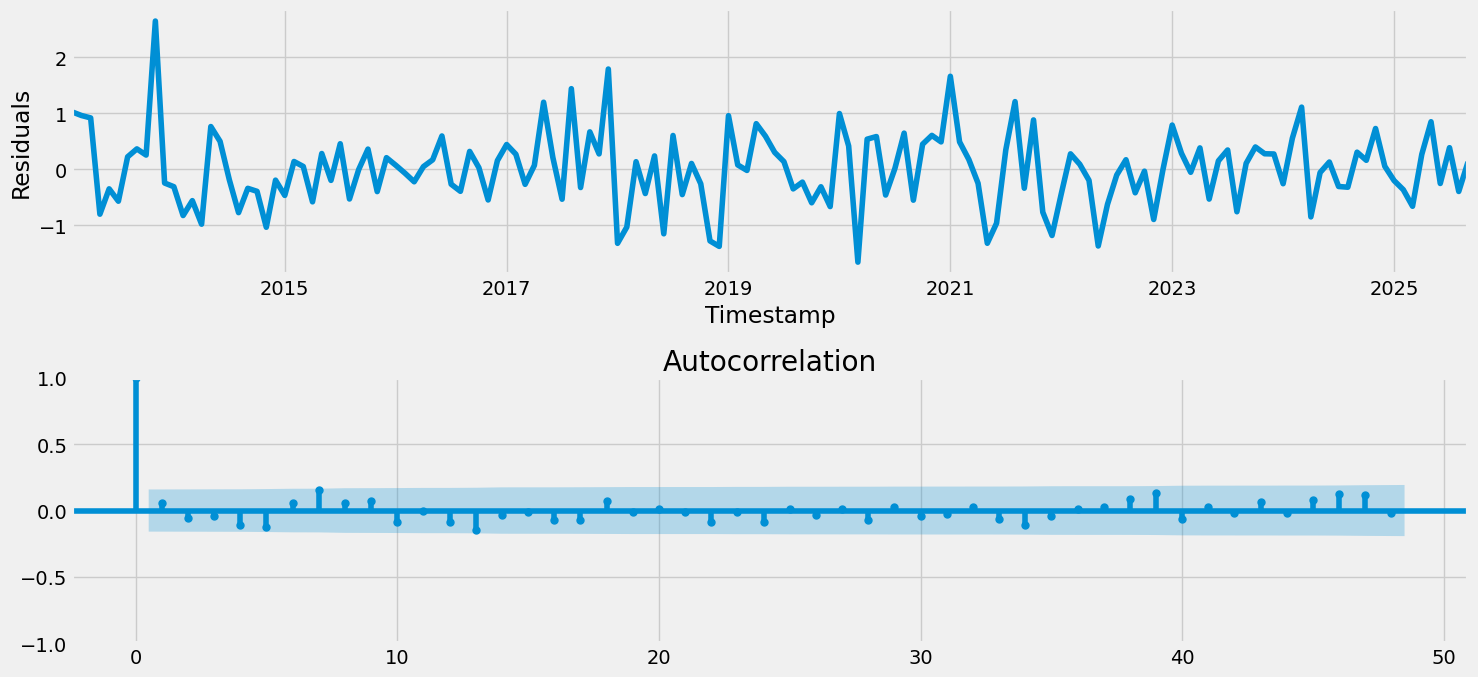

In [55]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [56]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

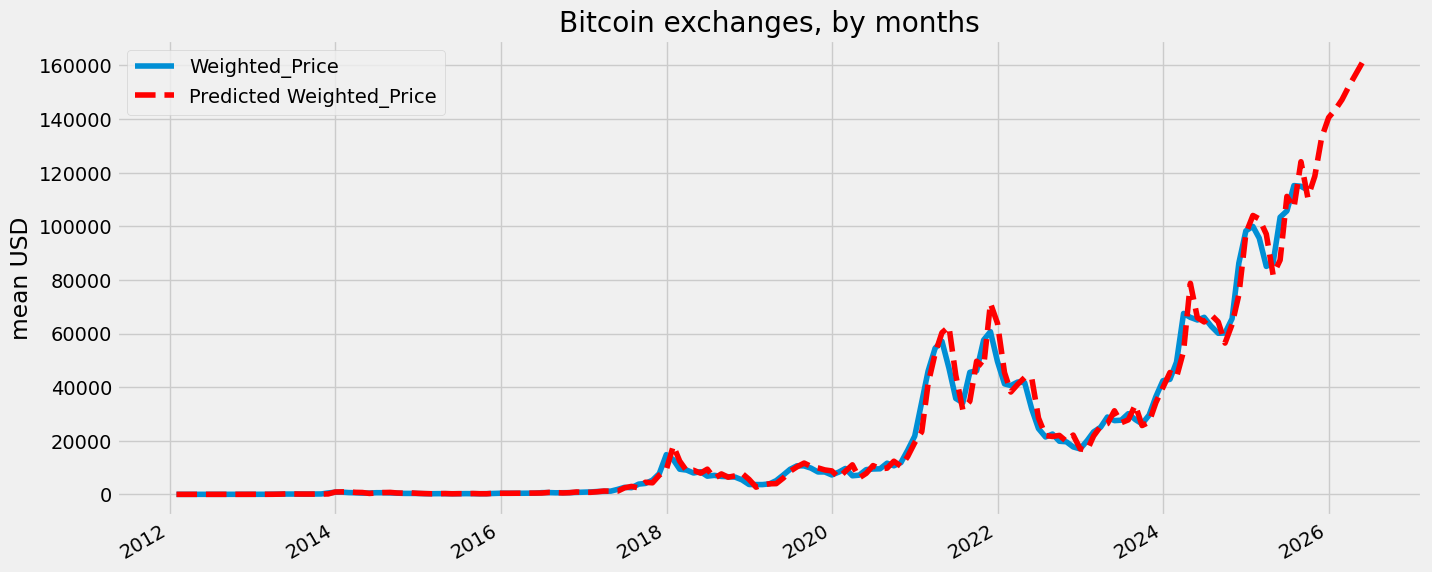

In [57]:
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2025, 9, 30), datetime(2025, 10, 31), datetime(2025, 11, 30), datetime(2025, 12, 31),
             datetime(2026, 1, 31), datetime(2026, 2, 28), datetime(2026, 3, 31), datetime(2026, 4, 30),
             datetime(2026, 5, 31)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=250), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

MAE: 0.480
RMSE: 0.536
MAPE: 1.69%
R²: 0.790


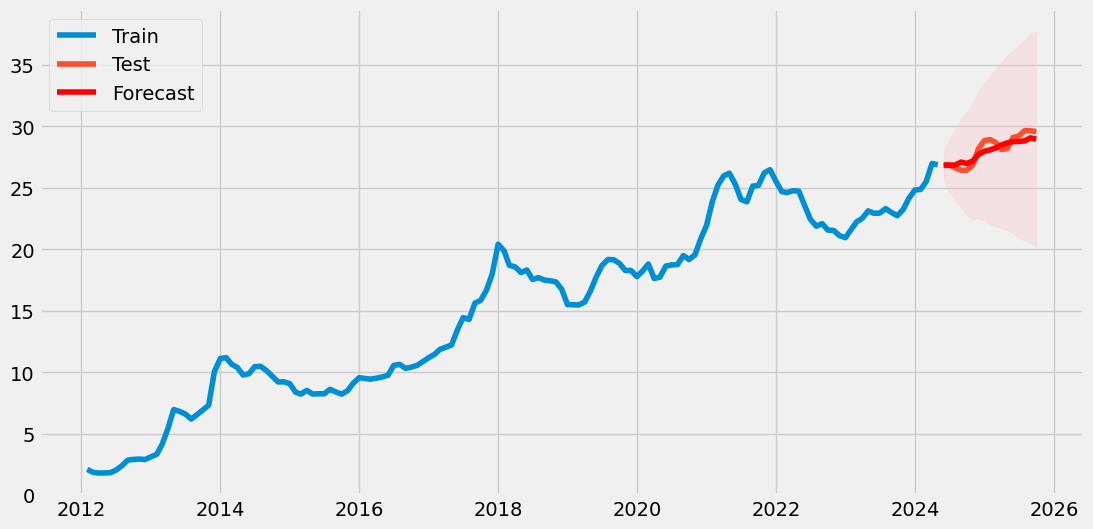

In [62]:
train = df_month.Weighted_Price_box[:int(0.9*len(df_month))]
test = df_month.Weighted_Price_box[int(0.9*len(df_month)):]

model = sm.tsa.statespace.SARIMAX(train,
                                  order=(best_param[0], d, best_param[1]),
                                  seasonal_order=(best_param[2], D, best_param[3], 12)).fit(disp=-1)

pred = model.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_mean = pred.predicted_mean
conf_int = pred.conf_int()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test, pred_mean)
rmse = mean_squared_error(test, pred_mean) ** 0.5
mape = (abs(test - pred_mean) / test).mean() * 100
r2 = r2_score(test, pred_mean)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.3f}")

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, pred_mean, label="Forecast", color="red")
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()

## LSTM

In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: pandas
    Found existing in

In [ ]:
import math
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import datetime as dt
import csv

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

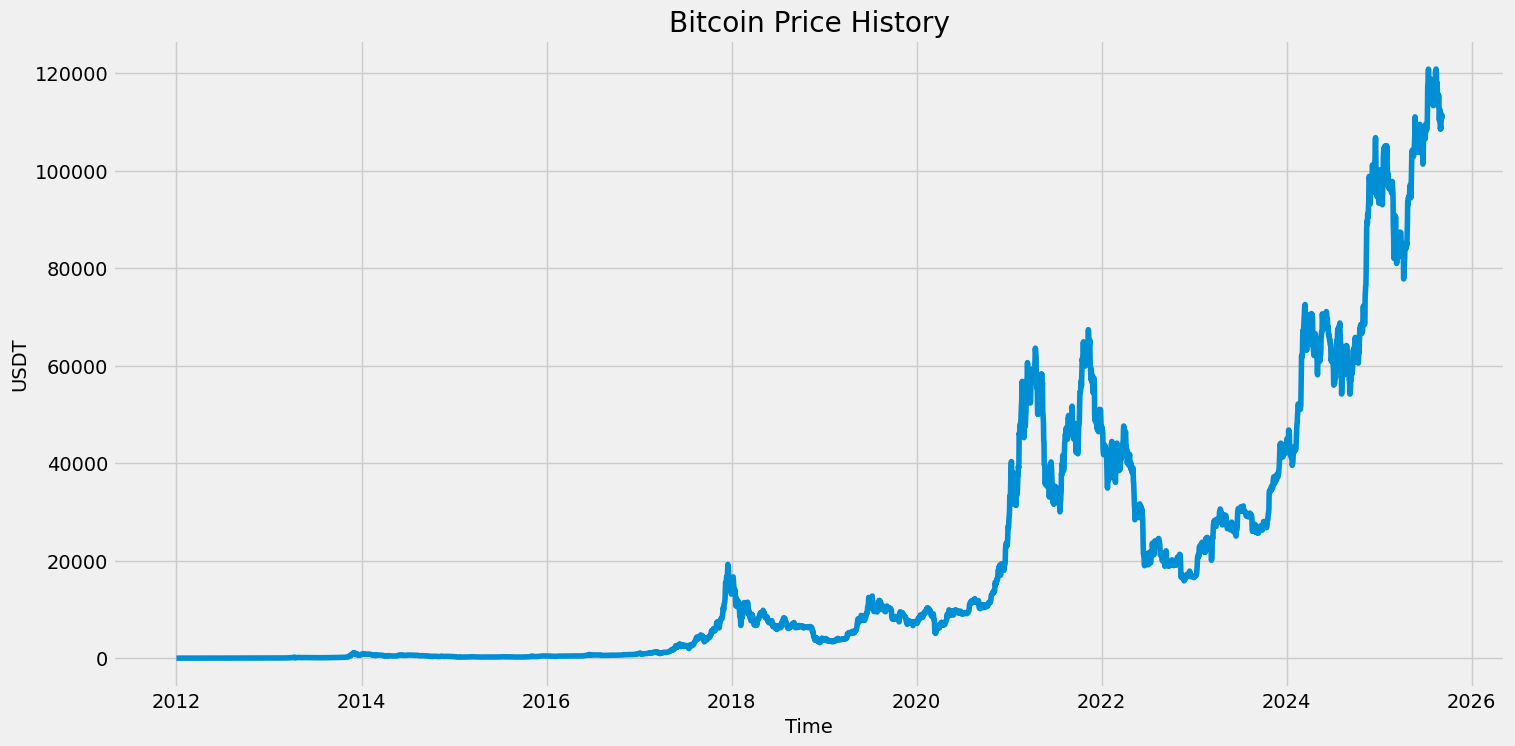

In [ ]:
# Visualize the close price history
plt.figure(figsize=(16, 8))
plt.title("Bitcoin Price History")
plt.plot(df_day.index, df_day["Close"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

[array([4.55337665e-06, 9.09394056e-06, 1.06175608e-05, 1.17881400e-05,
       2.25977811e-05, 3.17804846e-05, 2.38858492e-05, 3.45259119e-05,
       3.44846424e-05, 2.85455685e-05, 3.74337361e-05, 3.67293777e-05,
       3.29771087e-05, 3.00142266e-05, 3.16528460e-05, 3.80017423e-05,
       3.70978349e-05, 2.95469524e-05, 3.05954467e-05, 2.97777169e-05,
       3.63260665e-05, 3.12569078e-05, 3.15394746e-05, 3.01261617e-05,
       3.14194962e-05, 2.69509954e-05, 2.12196096e-05, 1.32503826e-05,
       1.71579629e-05, 1.57376601e-05, 1.85706055e-05, 1.55197265e-05,
       2.37588808e-05, 2.56449258e-05, 2.74831901e-05, 2.22456977e-05,
       1.71858270e-05, 1.85962673e-05, 1.89538086e-05, 2.02972219e-05,
       2.16127710e-05, 1.94062411e-05, 1.68740555e-05, 1.80837020e-05,
       1.37965572e-05, 7.80194663e-06, 3.90509069e-06, 5.09079890e-06,
       1.79086657e-06, 0.00000000e+00, 2.06711369e-06, 1.87972526e-06,
       2.62880023e-06, 4.93079580e-06, 1.08448782e-05, 9.53191435e-06,
     

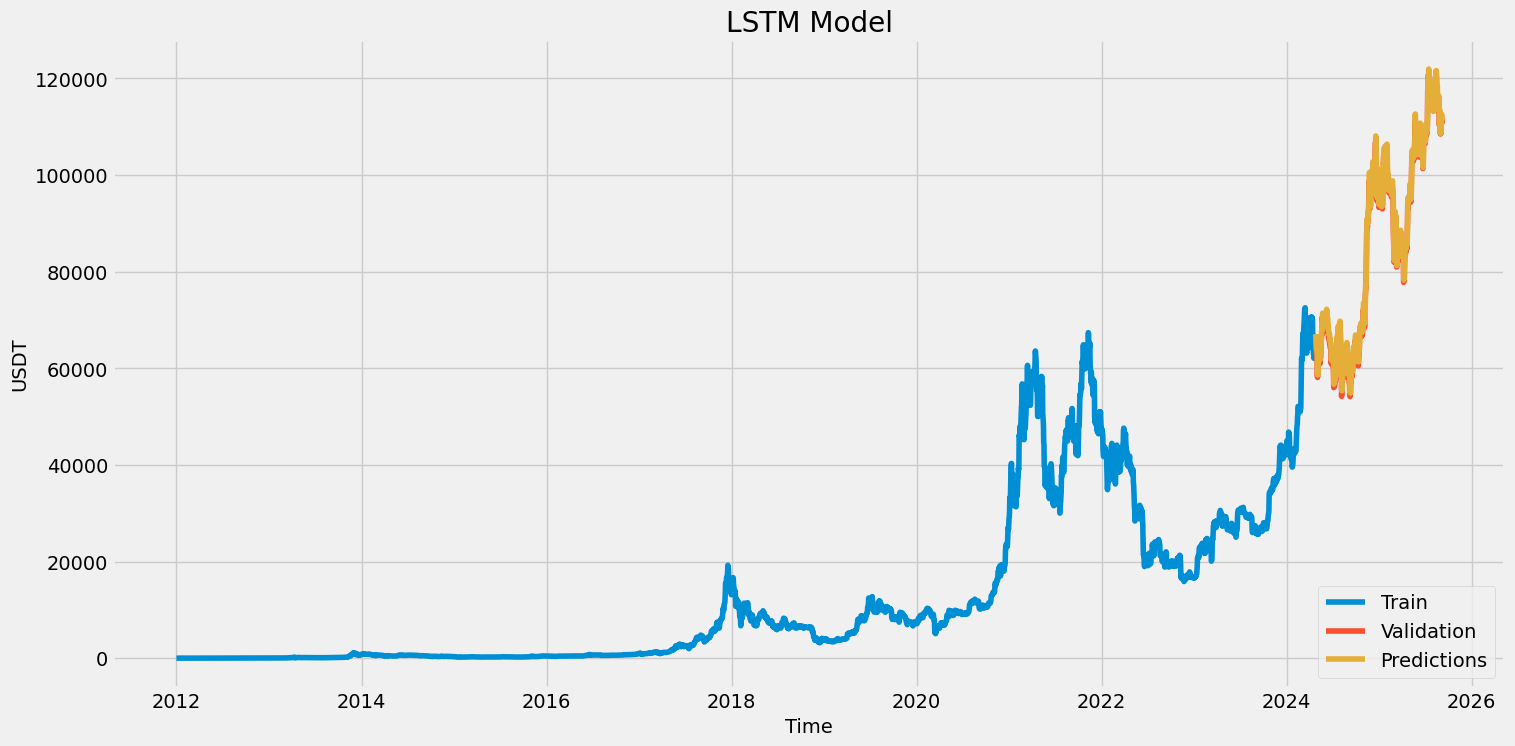

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Only keep Close column
close = df_day.filter(["Close"])
close_array = close.values

# Train length (90%)
train_close_len = math.ceil(len(close_array) * 0.9)

# Normalize (fit only on train to avoid leakage)
scaler = MinMaxScaler()
scaler.fit(close_array[:train_close_len])
scaled_data = scaler.transform(close_array)

# Training data
train_data = scaled_data[0:train_close_len, :]
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Testing data
test_data = scaled_data[train_close_len-60:, :]
X_test, y_test = [], close_array[train_close_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM Model
model = Sequential()
model.add(LSTM(units=512, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=256, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1, validation_split=0.1)

# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot
train = close[:train_close_len]
valid = close[train_close_len:]
valid.loc[:, "Predictions"] = predictions

plt.figure(figsize=(16, 8))
plt.title("LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(df_day.index[:train_close_len], train["Close"])
plt.plot(df_day.index[train_close_len:], valid[["Close", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0226 - mae: 0.0688 - val_loss: 9.6865e-04 - val_mae: 0.0211
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.3443e-04 - mae: 0.0099 - val_loss: 0.0012 - val_mae: 0.0294
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.9930e-04 - mae: 0.0097 - val_loss: 0.0030 - val_mae: 0.0446
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.7089e-04 - mae: 0.0113 - val_loss: 7.0004e-04 - val_mae: 0.0190
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.7918e-04 - mae: 0.0080 - val_loss: 0.0011 - val_mae: 0.0285
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.3712e-04 - mae: 0.0094 - val_loss: 6.9294e-04 - val_mae: 0.0174
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.3664e-04 - mae: 0.0100 - val_loss: 8.8411e-04 - val_mae: 0.0199
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.5508e-04 - mae: 0.0078 - val_loss: 5.3037e-04 - val_mae: 0.0168
Epoch 9/50
63/63

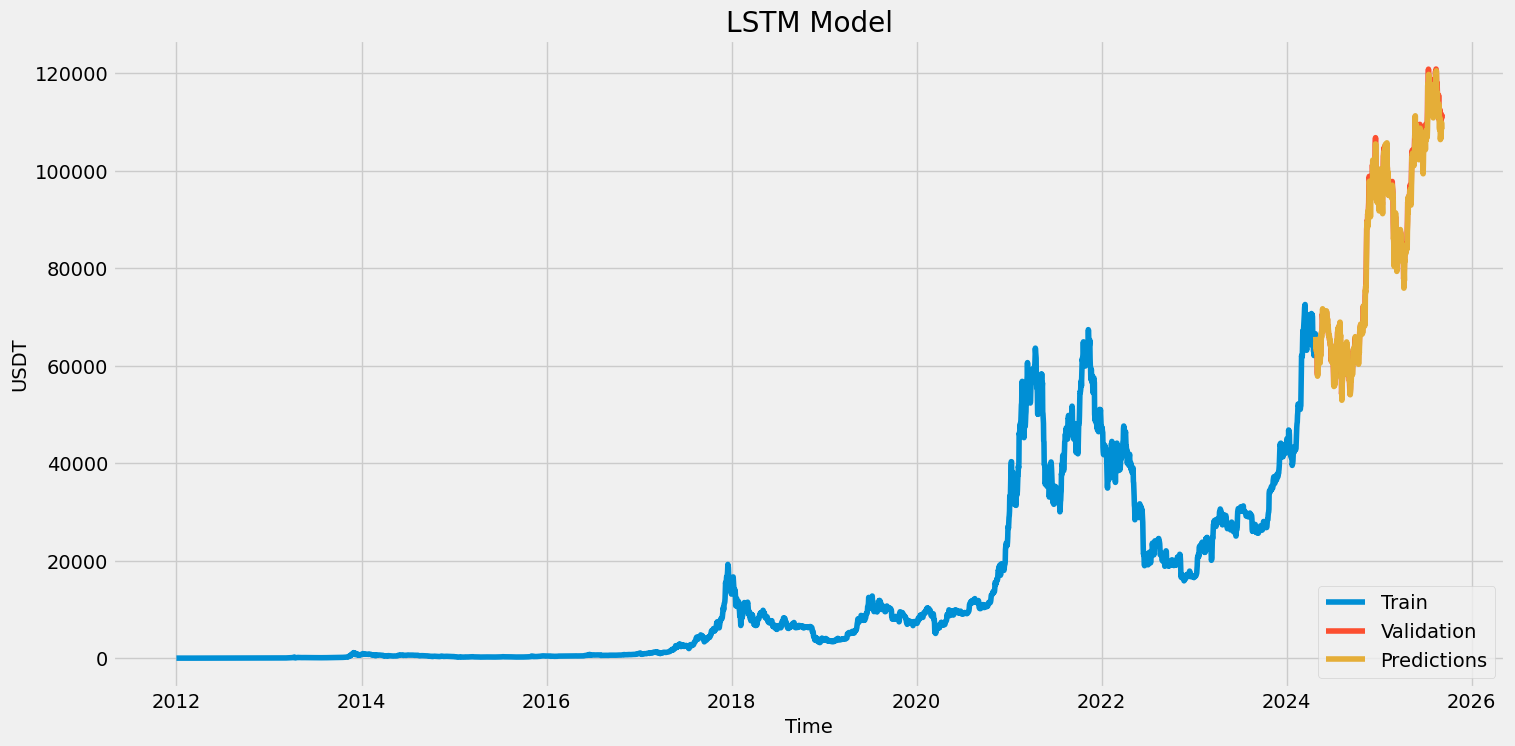

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Only keep Close column
close = df_day.filter(["Close"])
close_array = close.values

# Train length (90%)
train_close_len = math.ceil(len(close_array) * 0.9)

# Normalize (fit only on train to avoid leakage)
scaler = MinMaxScaler()
scaler.fit(close_array[:train_close_len])
scaled_data = scaler.transform(close_array)

# Training data
train_data = scaled_data[0:train_close_len, :]
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Testing data
test_data = scaled_data[train_close_len-60:, :]
X_test, y_test = [], close_array[train_close_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM Model
model = Sequential()
model.add(LSTM(units=512, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=256, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# Early stopping callback
early_stop = EarlyStopping(
    monitor="val_loss",   # watch validation loss
    patience=10,          # stop if no improvement for 10 epochs
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    verbose=1,
    validation_split=0.1,
    callbacks=[early_stop]
)

# Predictions on test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot train/valid
train = close[:train_close_len]
valid = close[train_close_len:]
valid.loc[:, "Predictions"] = predictions

plt.figure(figsize=(16, 8))
plt.title("LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(df_day.index[:train_close_len], train["Close"])
plt.plot(df_day.index[train_close_len:], valid[["Close", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
        Date  Predicted_Close
0 2025-09-06    110666.765625
1 2025-09-07    108042.968750
2 2025-09-08    105476.703125
3 2025-09-09    103083.218750
4 2025-09-10    100791.054688
5 2025-09-11     98565.906250
6 2025-09-12     96422.062500
7 2025-09-13     94388.679688
8 2025-09-14     92489.156250
9 2025-09-15     90735.375000


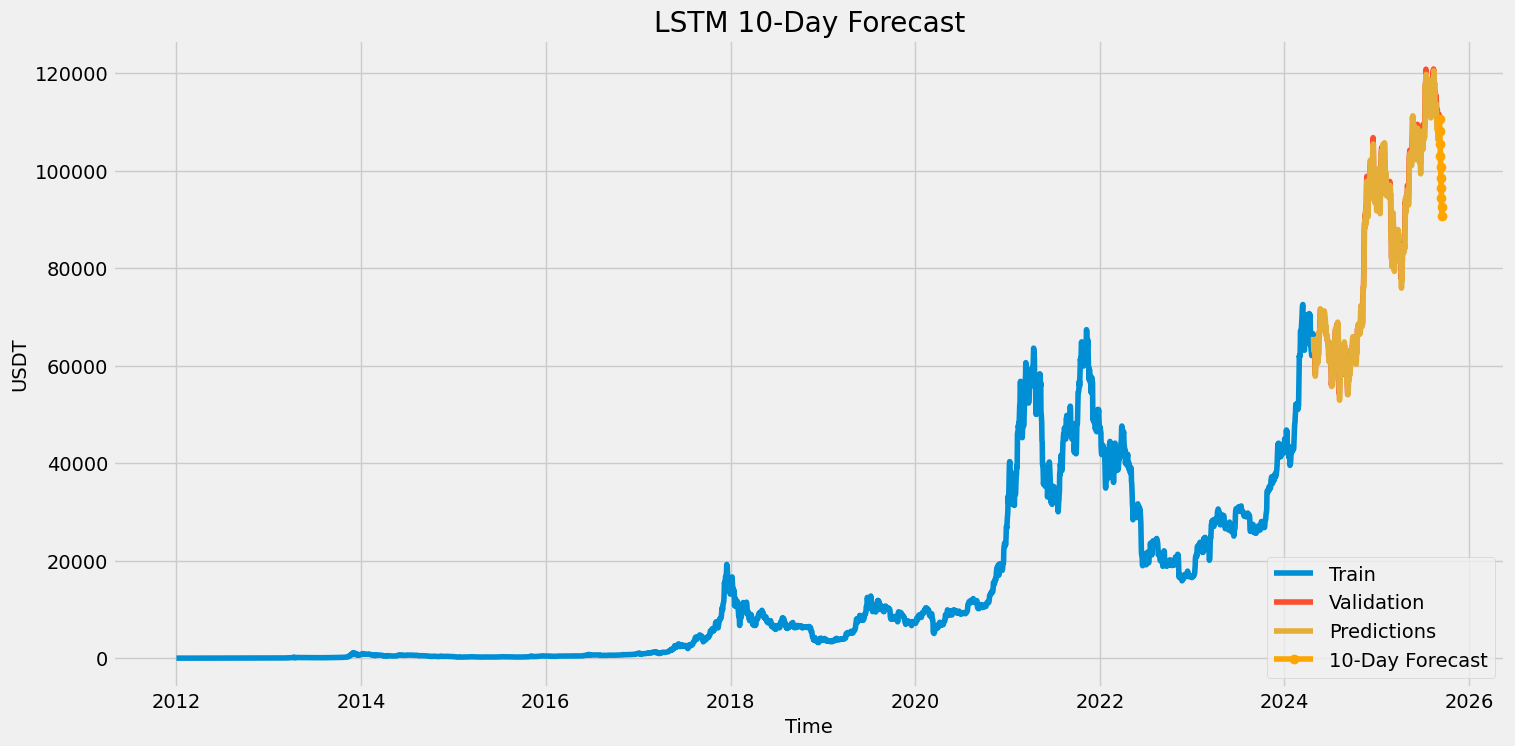

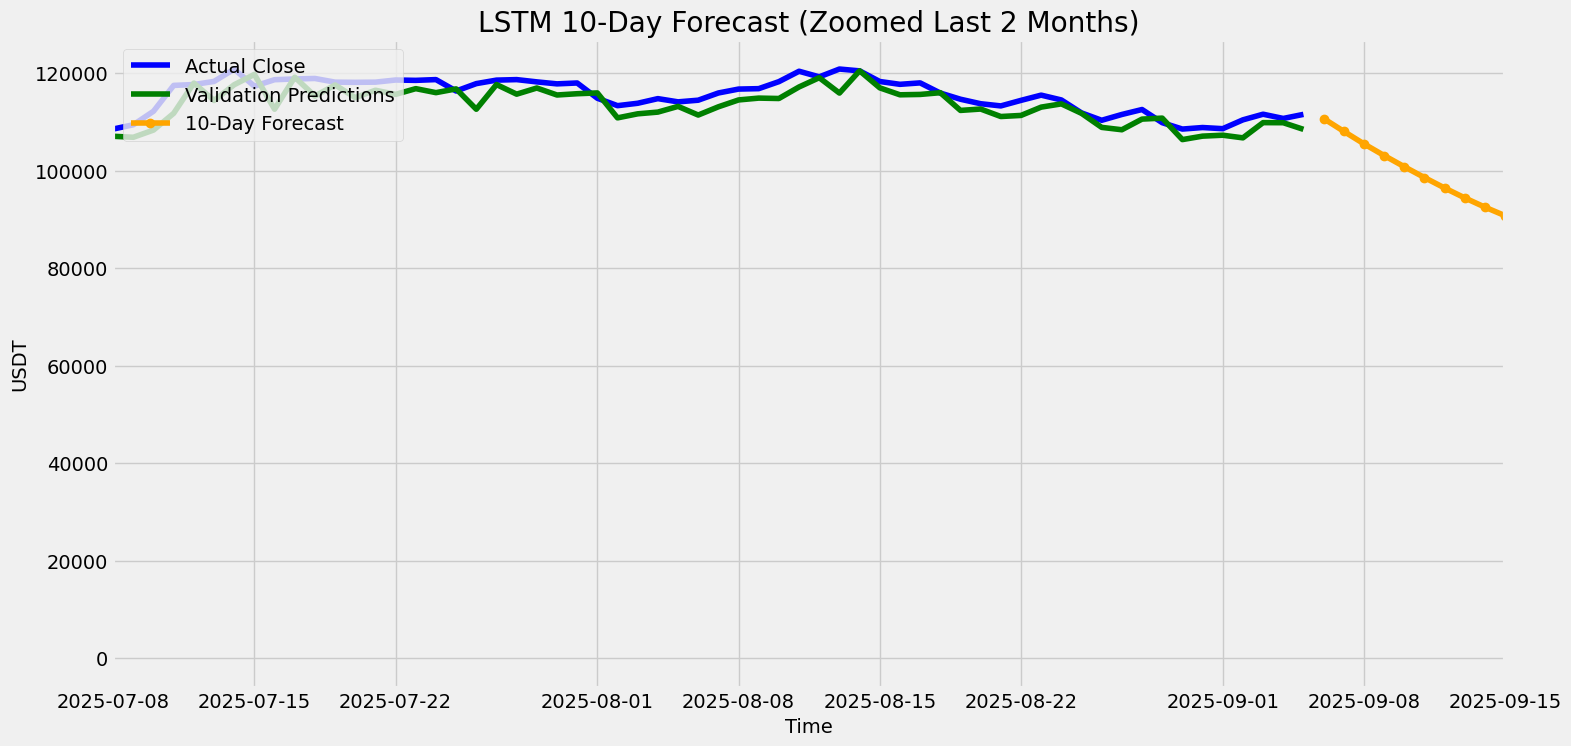

In [ ]:
# ------------------------------
# 🔮 Forecast next 10 days
# ------------------------------
future_days = 10
last_60 = scaled_data[-60:]   # last 60 days scaled
future_preds = []

current_input = last_60.reshape(1, 60, 1)

for _ in range(future_days):
    pred = model.predict(current_input)        # (1,1)
    future_preds.append(pred[0,0])

    pred_reshaped = pred.reshape(1,1,1)        # make (1,1,1)
    current_input = np.append(current_input[:,1:,:], pred_reshaped, axis=1)

# Inverse transform predictions back to original scale
future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

# Create future date index
last_date = df_day.index[-1]
future_index = pd.date_range(start=last_date, periods=future_days+1, freq="D")[1:]

future_df = pd.DataFrame({"Date": future_index, "Predicted_Close": future_preds.flatten()})
print(future_df)

# Plot historical + validation + future predictions
plt.figure(figsize=(16, 8))
plt.title("LSTM 10-Day Forecast")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)

# Plot historical train/validation
plt.plot(df_day.index[:train_close_len], train["Close"], label="Train")
plt.plot(df_day.index[train_close_len:], valid["Close"], label="Validation")
plt.plot(df_day.index[train_close_len:], valid["Predictions"], label="Predictions")

# Plot 10-day forecast continuation
plt.plot(future_df["Date"], future_df["Predicted_Close"], label="10-Day Forecast", color="orange", marker="o")

plt.legend(loc="lower right")
plt.show()

# Define window: last 60 days of actual + 10 days forecast
lookback_days = 60
plot_start = df_day.index[-lookback_days]

plt.figure(figsize=(16, 8))
plt.title("LSTM 10-Day Forecast (Zoomed Last 2 Months)")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)

# Plot actual close price for the last 2 months
plt.plot(df_day.index, df_day["Close"], label="Actual Close", color="blue")

# Plot validation predictions only in last 2 months
plt.plot(valid.index, valid["Predictions"], label="Validation Predictions", color="green")

# Plot 10-day forecast
plt.plot(future_df["Date"], future_df["Predicted_Close"],
         label="10-Day Forecast", color="orange", marker="o")

# Limit x-axis to last 2 months + forecast
plt.xlim(plot_start, future_df["Date"].iloc[-1])

plt.legend(loc="upper left")
plt.show()

In [ ]:
# change the parameters of first LSTM model and build the Optimized LSTM Model
optimized_model = Sequential()

optimized_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

optimized_model.add(LSTM(100, return_sequences=False))

optimized_model.add(Dense(50))

optimized_model.add(Dense(1))

In [ ]:
# compile the model
optimized_model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [ ]:
# train the optimized model
optimized_model.fit(X_train, y_train,
          batch_size=10,
          epochs=3,
          verbose=1)

Epoch 1/3
444/444 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0028 - mae: 0.0231
Epoch 2/3
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.8190e-04 - mae: 0.0081
Epoch 3/3
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.3330e-04 - mae: 0.0075


In [ ]:
# Predict with optimized LSTM model
o_predictions = optimized_model.predict(X_test)
o_predictions = scaler.inverse_transform(o_predictions)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


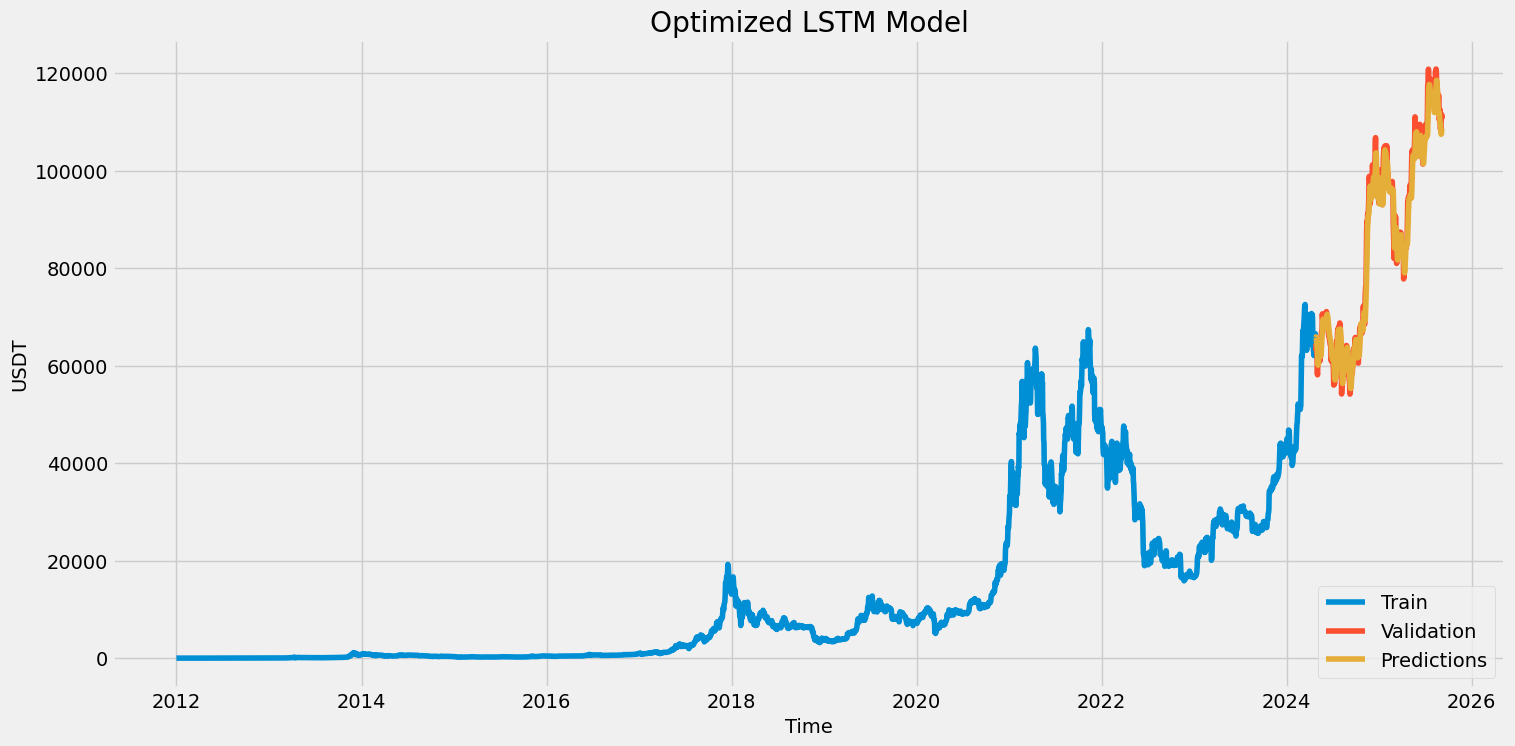

In [ ]:
# plot the data
train = close[:train_close_len]
valid = close[train_close_len:]
valid["Predictions"] = o_predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(df_day.index[:train_close_len], train["Close"])
plt.plot(df_day.index[train_close_len:], valid[["Close", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()

## XGBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error

# assume df_day has columns: ['Date','Close','Volume', ...]
data = df_day.copy()

# Ensure Date is datetime
data['Date'] = pd.to_datetime(data.index)

# Sort by date just in case
data = data.sort_values('Date').reset_index(drop=True)

# Log transform
data['log_close'] = np.log(data['Close'])

# 1) lags
for lag in [1, 2, 3, 7, 14, 21, 30, 60]:
    data[f'lag_{lag}'] = data['log_close'].shift(lag)

# 2) rolling stats
for w in [7, 14, 30, 60, 90]:
    data[f'roll_mean_{w}'] = data['log_close'].rolling(w).mean()
    data[f'roll_std_{w}']  = data['log_close'].rolling(w).std()
    data[f'roll_min_{w}']  = data['log_close'].rolling(w).min()
    data[f'roll_max_{w}']  = data['log_close'].rolling(w).max()

# 3) returns + vol
data['ret_1'] = data['log_close'] - data['log_close'].shift(1)
data['vol_7'] = data['ret_1'].rolling(7).std()

# 4) calendar features
data['dow'] = data['Date'].dt.dayofweek
data['month'] = data['Date'].dt.month

# drop rows with NaNs created by shifting/rolling
data = data.dropna().reset_index(drop=True)

# target: next-day log price
horizon = 1
data['target'] = data['log_close'].shift(-horizon)
data = data.dropna().reset_index(drop=True)

# features
feature_cols = [c for c in data.columns if c not in ['Date', 'Close', 'log_close', 'target']]

# TimeSeriesSplit / walk-forward
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

mae_scores = []
models = []

for train_idx, val_idx in tscv.split(data):
    X_train, y_train = data.loc[train_idx, feature_cols], data.loc[train_idx, 'target']
    X_val,   y_val   = data.loc[val_idx,   feature_cols], data.loc[val_idx,   'target']

    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    params = {
        'objective': 'regression',
        'metric': 'mae',
        'learning_rate': 0.03,
        'num_leaves': 128,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'seed': 42
    }

    bst = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dval],
        callbacks=[early_stopping(100), log_evaluation(100)]
    )

    pred = bst.predict(X_val, num_iteration=bst.best_iteration)
    mae = mean_absolute_error(np.exp(y_val), np.exp(pred))   # back-transform
    mae_scores.append(mae)
    models.append(bst)

print('MAE per fold:', mae_scores)
print('Mean MAE:', np.mean(mae_scores))

# To forecast next day(s): use last available row(s) features
last_row = data.iloc[-1:].copy()
next_pred_log = models[-1].predict(last_row[feature_cols])[0]
next_price = np.exp(next_pred_log)
print('Next day predicted price:', next_price)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7960
[LightGBM] [Info] Number of data points in the train set: 822, number of used features: 36
[LightGBM] [Info] Start training from score 4.196412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in